In [2]:
import pandas as pd
from collections import Counter
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import re, json
import time
import warnings 
warnings.filterwarnings('ignore') 
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
plt.style.use('bmh')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats
pd.set_option('display.max_rows', 10)

C:\Users\tuank\AppData\Local\Temp\ipykernel_17908\3388473053.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data collection:

In [ ]:
# Hàm lấy đường dẫn
def get_url(page):
    if page > 1:
        url = 'https://batdongsan.vn/ban-nha-ho-chi-minh/p' + str(page)
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    else:
        org_url = 'https://batdongsan.vn/ban-nha-ho-chi-minh'
        response = requests.get(org_url)
        soup = BeautifulSoup(response.text, 'html.parser')
    for i in range(0, 20):
        result = soup.find_all('div', {'class': 'name'})[i]
        url = result.find('a').get('href')
        urls.append(url)

In [ ]:
# Hàm lấy số tầng
def num_floors(text):
    numbers = re.findall(r'\b\d+\b', text)
    for number in numbers:
        pattern = f'{number}\s*(tầng|lầu)'
        if re.search(pattern, text, re.IGNORECASE):
            return int(number)
    return None

# Hàm lấy phòng ngủ trong mô tả
def num_bedrooms(text):
    numbers = re.findall(r'\b\d+\b', text)
    for number in numbers:
        pattern = f'{number}\s*(phòng ngủ)'
        if re.search(pattern, text, re.IGNORECASE):
            return int(number)
    return None

# Hàm lấy phòng wc trong mô tả
def num_wcs(text):
    numbers = re.findall(r'\b\d+\b', text)
    for number in numbers:
        pattern = f'{number}\s*(phòng wc)'
        if re.search(pattern, text, re.IGNORECASE):
            return int(number)
    return None

In [ ]:
# Hàm lấy thuộc tính
def get_attributes(url):
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    mô_tả = soup.find('div', class_ = 'content').get_text(strip = True)

    # Môi giới
    try:
      môi_giới_tag = soup.find('div', class_ = "name")
      môi_giới = môi_giới_tag.get_text()
    except:
      môi_giới = None
        
    # Diện tích
    try:
        diện_tích_tag = soup.find('strong', text = 'Diện tích:')
        diện_tích = diện_tích_tag.next_sibling.strip() + diện_tích_tag.next_sibling.next.text
        match = re.search(r'\b(\d+)\b', diện_tích)
        if match:
            diện_tích = int(match.group(0))
        else:
            diện_tích = None
    except:
        diện_tích = None

    # Giá
    try:
        pattern = r'(\d+(\.\d+)?)\s(\w*)'
        giá = soup.find('strong', {'class': 'price'}).text.strip()
        match = re.findall(pattern, giá)
        if len(match[0]) == 2:
            a = []
            a.append(int(match[0][0]))
            a.append(match[0][1])
            if a[1] == 'triệu':
                a[0] = a[0]/1000
            else:
                if a[0] > 1000000000:
                    a[0] = a[0]/1000000000
        else:
            a = []
            a.append(float(match[0][0]))
            a.append(match[0][2])
            if a[1] == 'triệu':
              a[0] = a[0]/1000
            else:
                if a[0] > 1000000000:
                    a[0] = a[0]/1000000000
        giá = a[0]
    except:
        giá = None
              
    # Phòng ngủ
    try:
        phòng_ngủ_tag = soup.find('strong', text = 'Phòng ngủ:')
        phòng_ngủ = phòng_ngủ_tag.next_sibling.strip()
        phòng_ngủ = int(''.join(re.findall(r'\d+', phòng_ngủ)))
        if phòng_ngủ is None:
            phòng_ngủ = num_bedrooms(mô_tả)
    except:
        phòng_ngủ = None
        
    # Phòng WC
    try:
        phòng_wc_tag = soup.find('strong', text = 'Phòng WC:')
        phòng_wc = phòng_wc_tag.next_sibling.strip()
        phòng_wc = int(''.join(re.findall(r'\d+', phòng_wc)))
        if phòng_wc is None:
            phòng_wc = num_wcs(mô_tả)
    except:
        phòng_wc = None
        
    # Tỉnh, thành
    try:
        tỉnh_thành_tag = soup.find_all('ul', class_ = 'uk-breadcrumb')[0]
        tỉnh_thành = tỉnh_thành_tag.find_all('li')[2].text
    except:
        tỉnh_thành = None

    # Quận
    try:
        quận_tag = soup.find_all('ul', class_ = 'uk-breadcrumb')[0]
        quận = quận_tag.find_all('li')[3].text
    except:
        quận = None

    # Mã tin
    try:
        mã_tin_tag = soup.find('strong', text = 'Mã tin:')
        mã_tin = mã_tin_tag.next_sibling.strip()
    except:
        mã_tin = None

    # Ngày đăng
    try:
        ngày_đăng_tag = soup.find('time', class_ = "timeago")
        ngày_đăng = ngày_đăng_tag.text
    except:
        ngày_đăng = None

    # Môi giới
    try:
        meta_div = môi_giới_tag.find_next_sibling('div', class_ = 'meta')
        pattern = r'\d+'
        a10 = meta_div.find_all('span')
        if len(a10) == 1:
            n = a10[0].get_text()
            match = re.findall(pattern, n)
            địa_chỉ_môi_giới = None
            bài_đăng = int(match[0])
        else:
            địa_chỉ_môi_giới = a10[0].get_text()
            bài_đăng = a10[1].get_text()
            n = a10[1].get_text()
            match = re.findall(pattern, n)
            bài_đăng = int(match[0])
    except:
        địa_chỉ_môi_giới = None
        bài_đăng = None
    
    # Email
    try:
        email_tag = soup.find('div', class_ = "more email").find('a').get('href')
        email = email_tag.split(':')[1]
    except:
        email = None

    # Số điện thoại
    try:
        sdt_tag = soup.find('div', class_ = "more phone")
        sdt = sdt_tag.find('a').get('href')
        sdt = sdt.split(':')[1]
    except:
        sdt=None
           
    return giá, diện_tích, num_floors(mô_tả), phòng_ngủ, phòng_wc, tỉnh_thành, quận, mã_tin, ngày_đăng, môi_giới, email, sdt, địa_chỉ_môi_giới, bài_đăng

In [ ]:
df = pd.DataFrame()
data = {}
urls = []
start_time = time.time()
with ThreadPoolExecutor(250) as executor:
    futures = [executor.submit(get_url, page) for page in range(1, 300)]
    for future in as_completed(futures):
        future.result()
    futures = [executor.submit(get_attributes, url) for url in urls]
    for future in as_completed(futures):        
        data['Giá bán (tỷ)'], data['Diện tích (m2)'], data['Số tầng'], data['Phòng ngủ'], data['Phòng WC'], data['Tỉnh'], data['Quận, Huyện'], data['Mã tin'], data['Ngày đăng'], data['Môi giới'], data['Email'], data['Số điện thoại'], data['Địa chỉ người môi giới'], data['Số bài đăng'] = future.result()      
        df = pd.concat([df, pd.DataFrame([data])], ignore_index = True)
end_time = time.time()
total_time = end_time - start_time

In [ ]:
total_time

714.535117149353

In [ ]:
df.drop_duplicates(inplace = True)
df['Diện tích (m2)'] = df['Diện tích (m2)'].astype('Int64')
df['Giá bán (tỷ)'] = df['Giá bán (tỷ)'].replace('', float('nan'))
df['Giá bán (tỷ)'] = round(df['Giá bán (tỷ)'].astype('float64'), 2)
df['Phòng ngủ'] = df['Phòng ngủ'].astype('Int64')
df['Phòng WC'] = df['Phòng WC'].astype('Int64')
df['Số tầng'] = df['Số tầng'].astype('Int64')
df['Số bài đăng'] = df['Số bài đăng'].astype('Int64')
df.shape

Giá bán (tỷ)              float64
Diện tích (m2)              Int64
Số tầng                     Int64
Phòng ngủ                   Int64
Phòng WC                    Int64
Tỉnh                       object
Quận, Huyện                object
Mã tin                     object
Ngày đăng                  object
Môi giới                   object
Email                      object
Số điện thoại              object
Địa chỉ người môi giới     object
Số bài đăng                 Int64
dtype: object

In [ ]:
csv_file_path = 'new_data.csv'
df.to_csv(csv_file_path, index = False) 

In [3]:
#Đọc file dữ liệu gốc và lưu vào dataframe
df = pd.read_csv('new_data.csv')
df.dtypes

Giá bán (tỷ)              float64
Diện tích (m2)            float64
Số tầng                   float64
Phòng ngủ                 float64
Phòng WC                  float64
                           ...   
Môi giới                   object
Email                      object
Số điện thoại             float64
Địa chỉ người môi giới     object
Số bài đăng                 int64
Length: 14, dtype: object

In [4]:
#Kiểm tra các features của tập dữ liệu
df.columns

Index(['Giá bán (tỷ)', 'Diện tích (m2)', 'Số tầng', 'Phòng ngủ', 'Phòng WC',
       'Tỉnh', 'Quận, Huyện', 'Mã tin', 'Ngày đăng', 'Môi giới', 'Email',
       'Số điện thoại', 'Địa chỉ người môi giới', 'Số bài đăng'],
      dtype='object')

In [5]:
#Kiểm tra kích thước của tập dữ liệu
df.shape

(5980, 14)

In [6]:
#Kiểm tra có bộ dữ liệu nào trùng lặp không
df.duplicated().sum()

0

# Select appropriate data features for training the models

In [7]:
#Chọn các feature phù hợp cho việc dự đoán giá nhà
#Ở đây, ta sẽ lược bỏ các thông tin như 'Mã tin', 'Ngày đăng', 'Môi giới', 'Email', 'Số điện thoại', 'Địa chỉ người môi giới', 'Số bài đăng'
#Với vấn đề bài toán là đoán giá nhà ở TP.HCM, ta cũng sẽ lược bỏ feature 'Tỉnh'
df = df[['Diện tích (m2)', 'Số tầng', 'Phòng ngủ', 'Phòng WC', 'Quận, Huyện', 'Giá bán (tỷ)']]

# Handling missing values

In [8]:
#Kiểm tra các features bị khuyết
#Hầu hết các features đều bị khuyết, ta sẽ tiến hành xử lí lần lượt các missing value của features
df.isnull().sum()

Diện tích (m2)     693
Số tầng           1268
Phòng ngủ         2493
Phòng WC          2767
Quận, Huyện          0
Giá bán (tỷ)       604
dtype: int64

In [9]:
#Do target của bài toán là giá bán nên ta sẽ loại đi các bộ dữ liệu bị khuyết giá bán
drop_index = df[df['Giá bán (tỷ)'].isnull()].index
df = df.drop(drop_index)

In [10]:
df['null_count'] = df.isna().sum(axis = 1)
df = df[df['null_count'] < 3]
df = df.drop('null_count', axis = 1)

In [11]:
df.isnull().sum()

Diện tích (m2)      34
Số tầng            648
Phòng ngủ         1376
Phòng WC          1641
Quận, Huyện          0
Giá bán (tỷ)         0
dtype: int64

In [12]:
#Do feature diện tích chỉ bị khuyết ở 34 dòng, rất nhỏ so với tổng thể nên ta loại bỏ các dòng chứa giá trị null của feature này
drop_index = df[df['Diện tích (m2)'].isnull()].index
df = df.drop(drop_index)

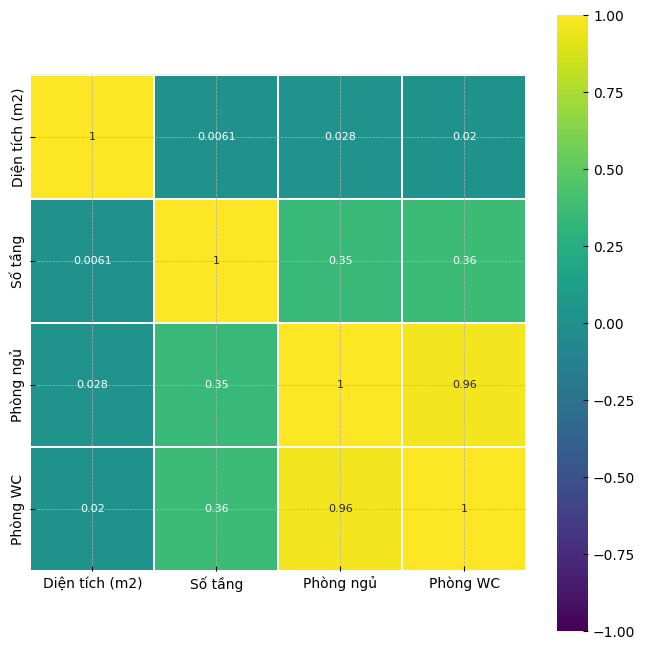

In [13]:
#Xem tương quan giữa các features
check_df = df.dropna(subset = ['Phòng ngủ', 'Phòng WC', 'Số tầng', 'Diện tích (m2)'])
corr = check_df.drop(['Giá bán (tỷ)', 'Quận, Huyện'], axis = 1).corr()
plt.figure(figsize = (8, 8))
sns.heatmap(corr, cmap = 'viridis', vmax = 1.0, vmin = -1.0, linewidths = 0.1, annot = True, annot_kws = {"size": 8}, square = True);

In [14]:
#Dễ thấy, số phòng ngủ và số phòng WC có hệ số tương quan rất cao (>0.9), do đó ta có thể dự đoán 1 trong 2 feature thông qua feature còn lại
#Ta sẽ áp dụng linear regression để dự đoán cho các giá trị bị khuyết ở 2 feature này
bedrooms = np.array(check_df['Phòng ngủ']).reshape(-1, 1)
wc = np.array(check_df['Phòng WC']).reshape(-1, 1)
model = LinearRegression()
model.fit(bedrooms, wc)
#In ra hệ số cho phương trình hồi quy tuyến tính
coef = model.coef_[0][0]
intercept = model.intercept_[0]
print(f'Phương trình hồi quy tuyến tính: Phòng WC = {coef:.4f} * Phòng ngủ + {intercept:.4f}')

Phương trình hồi quy tuyến tính: Phòng WC = 0.9594 * Phòng ngủ + -0.0082


In [15]:
#Như vậy, với bộ dữ liệu trên, số phòng ngủ xấp xỉ bằng số phòng wc
#Ta sẽ điền vào dataframe các giá trị phòng ngủ và phòng wc ở các hàng bị khuyết 1 trong 2 thuộc tính
missing_bedrooms = df['Phòng ngủ'].isna()
missing_wc = df['Phòng WC'].isna()
df.loc[missing_bedrooms, 'Phòng ngủ'] = df.loc[missing_bedrooms, 'Phòng WC']
df.loc[missing_wc, 'Phòng WC'] = df.loc[missing_wc, 'Phòng ngủ']

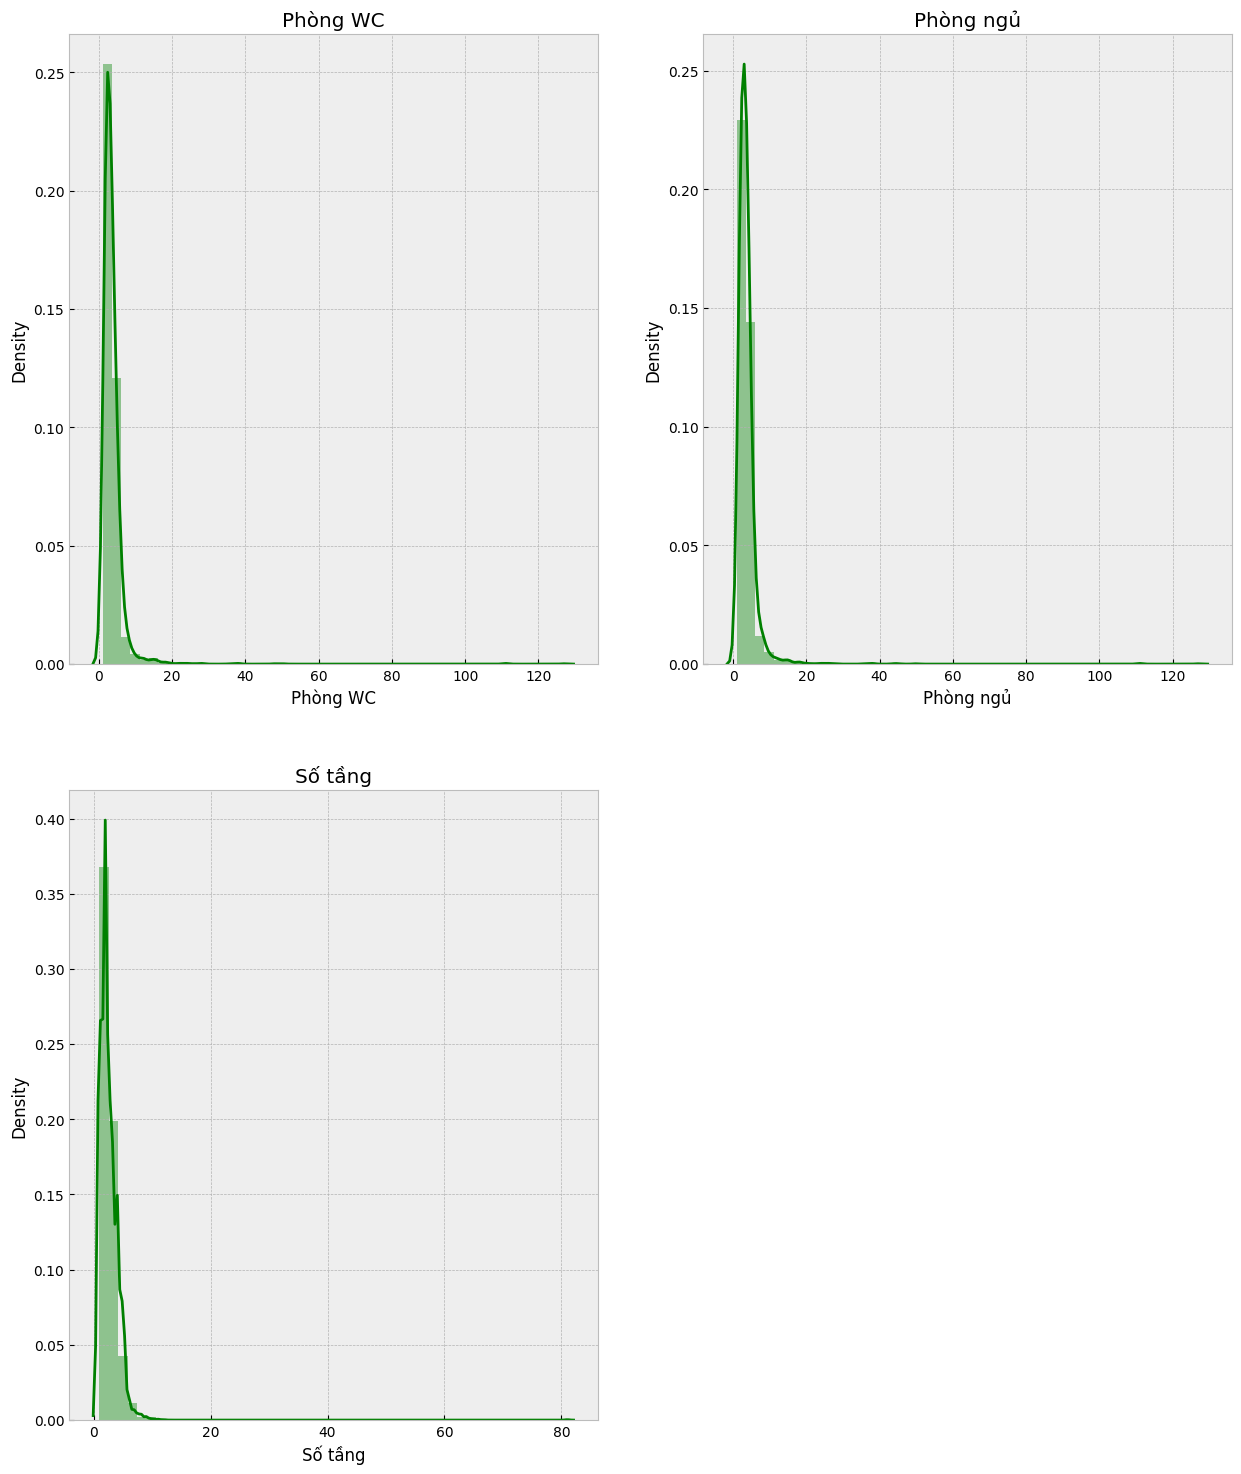

In [16]:
#Ta xem các biểu đồ biểu diễn phân phối của các feature phòng ngủ, phòng wc, số tầng
plot_df = df[['Phòng WC', 'Phòng ngủ', 'Số tầng']]
chart, axs = plt.subplots(2, 2, figsize=(15, 18))
n = 0
for i in range(2):
    for j in range(2):
        if n< len(plot_df.columns):
            sns.distplot(plot_df[plot_df.columns[n]], ax = axs[i, j], color='g')
            axs[i, j].set_title(plot_df.columns[n])
        else:
            axs[i, j].axis('off')
        n = n+1
plt.show()

In [17]:
#Dễ thấy các biểu đồ đều tập trung chủ yếu ở 1-2 giá trị và các biến phòng ngủ, phòng wc, số tầng đều là biến rời rạc
#Do đó, với các giá trị bị khuyết còn lại của các feature trên, ta có thể thay thế bằng giá trị mode
for column in ['Phòng WC', 'Phòng ngủ', 'Số tầng']:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)

In [18]:
df.isnull().sum()

Diện tích (m2)    0
Số tầng           0
Phòng ngủ         0
Phòng WC          0
Quận, Huyện       0
Giá bán (tỷ)      0
dtype: int64

# Handling Outliers

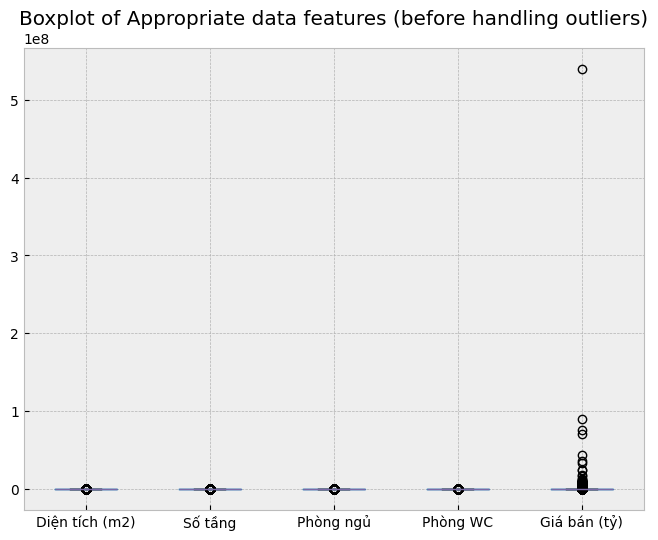

In [19]:
# Using boxplot to show outliers
plt.figure(figsize = (8, 6))
df.boxplot()
plt.title('Boxplot of Appropriate data features (before handling outliers)')
plt.show()

In [20]:
df.describe()

,Diện tích (m2),Số tầng,Phòng ngủ,Phòng WC,Giá bán (tỷ)
count,4621.000000,4621.000000,4621.000000,4621.000000,4.621000e+03
mean,84.448821,2.482580,3.260982,3.136551,3.818915e+05
std,489.526180,1.747964,3.764704,3.759514,8.325345e+06
min,8.000000,1.000000,1.000000,1.000000,1.000000e-02
25%,44.000000,2.000000,2.000000,2.000000,4.100000e+00
50%,60.000000,2.000000,2.000000,2.000000,5.700000e+00
75%,80.000000,3.000000,4.000000,4.000000,9.800000e+00
max,32825.000000,81.000000,127.000000,127.000000,5.400000e+08


In [21]:
#Tiến hành lọc giá trị ngoại lai cho các feature và target (ngoài Quận, huyện)
df_no_outliers = df.copy()
for i in list(range(4)) + [5]:
    column = df.columns[i]
    Q1 = np.percentile(df[df.columns[i]], 25)
    Q3 = np.percentile(df[df.columns[i]], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.5 * IQR
    upper_bound = Q3 + 3.5 * IQR
    df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]

In [22]:
df_no_outliers

,Diện tích (m2),Số tầng,Phòng ngủ,Phòng WC,"Quận, Huyện",Giá bán (tỷ)
1,58.0,5.0,4.0,4.0,Gò Vấp,9.70
2,80.0,2.0,4.0,4.0,Quận 2,16.00
3,50.0,2.0,3.0,4.0,Bình Thạnh,4.90
4,48.0,1.0,2.0,2.0,Tân Phú,3.30
5,50.0,3.0,4.0,3.0,Quận 7,4.30
...,...,...,...,...,...,...
5974,39.0,2.0,2.0,2.0,Bình Tân,3.60
5975,26.0,2.0,2.0,4.0,Phú Nhuận,5.50
5976,100.0,2.0,2.0,1.0,Hóc Môn,0.01
5977,45.0,5.0,4.0,3.0,Gò Vấp,7.15


<Axes: >

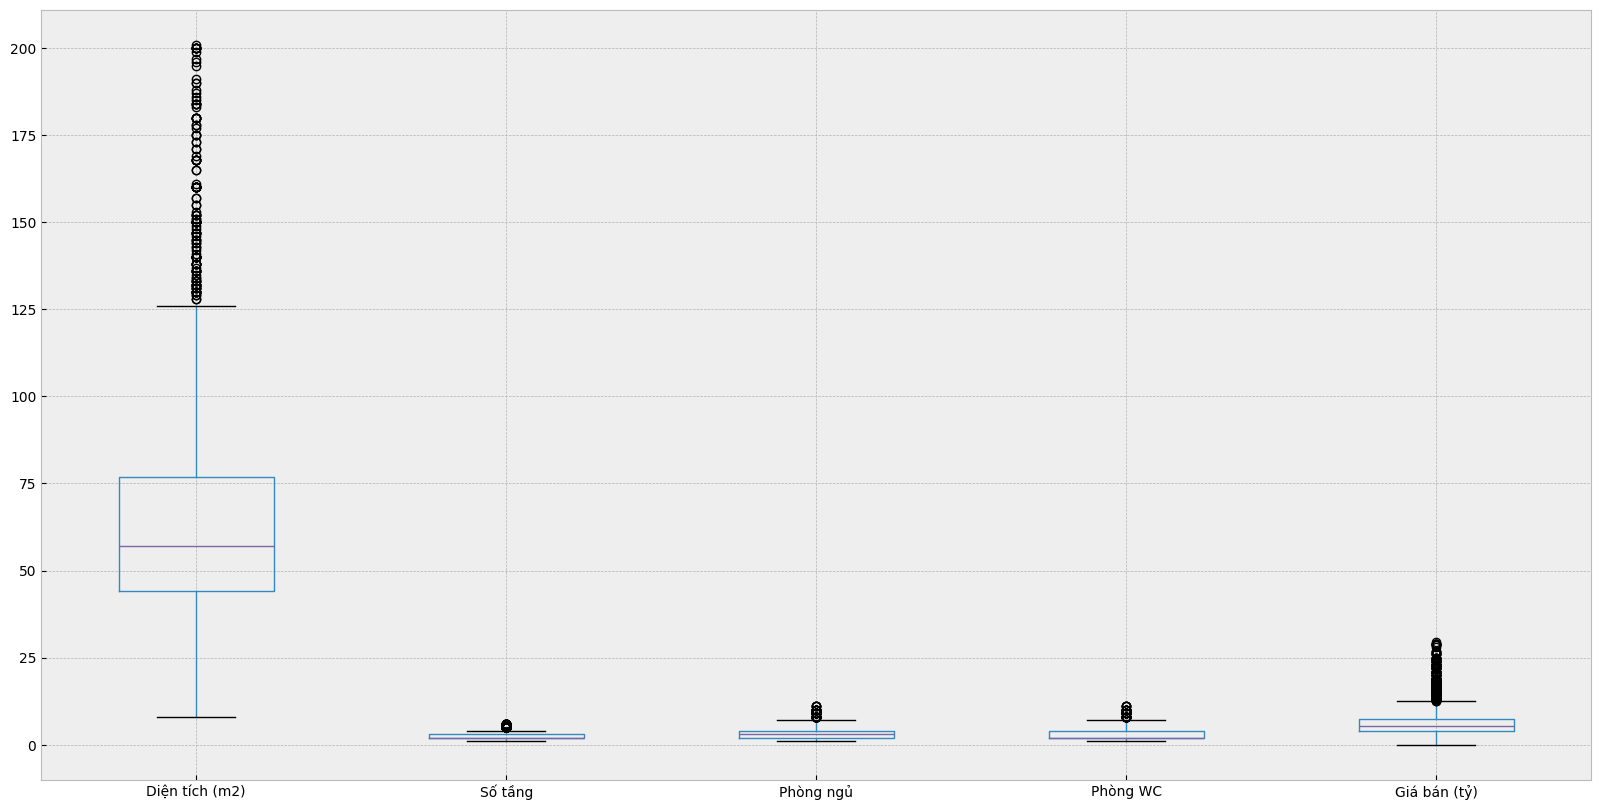

In [23]:
plt.figure(figsize=(20, 10))
df_no_outliers.boxplot()

In [24]:
#Xem các giá bán quá thấp có thể chưa được lọc
pd.set_option('display.max_rows', None)
df_no_outliers[df_no_outliers['Giá bán (tỷ)'] < 1].sort_values(by = 'Giá bán (tỷ)')

,Diện tích (m2),Số tầng,Phòng ngủ,Phòng WC,"Quận, Huyện",Giá bán (tỷ)
5976,100.0,2.0,2.0,1.0,Hóc Môn,0.01
4782,48.0,3.0,4.0,4.0,Bình Thạnh,0.01
4692,64.0,3.0,2.0,2.0,Bình Tân,0.01
3363,46.0,1.0,2.0,2.0,Quận 1,0.01
3031,80.0,1.0,2.0,2.0,Bình Tân,0.01
1818,98.0,2.0,3.0,2.0,Quận 12,0.01
1449,68.0,5.0,5.0,4.0,Tân Phú,0.01
1536,80.0,2.0,2.0,2.0,Bình Tân,0.02
1498,80.0,2.0,2.0,2.0,Bình Tân,0.02
688,80.0,2.0,1.0,2.0,Quận 1,0.05


In [25]:
#Dễ thấy các giá bán quá thấp (do việc nhập liệu sai của người bán) vẫn chưa được lọc khỏi df, do đó ta sẽ tiến hành lọc các giá trị ấy
pd.set_option('display.max_rows', 10)
df_no_outliers = df_no_outliers[df_no_outliers['Giá bán (tỷ)'] >= 0.4]
df_no_outliers.reset_index(drop = True, inplace = True)
df_no_outliers

,Diện tích (m2),Số tầng,Phòng ngủ,Phòng WC,"Quận, Huyện",Giá bán (tỷ)
0,58.0,5.0,4.0,4.0,Gò Vấp,9.70
1,80.0,2.0,4.0,4.0,Quận 2,16.00
2,50.0,2.0,3.0,4.0,Bình Thạnh,4.90
3,48.0,1.0,2.0,2.0,Tân Phú,3.30
4,50.0,3.0,4.0,3.0,Quận 7,4.30
...,...,...,...,...,...,...
3970,160.0,2.0,4.0,4.0,Thủ Đức,11.00
3971,39.0,2.0,2.0,2.0,Bình Tân,3.60
3972,26.0,2.0,2.0,4.0,Phú Nhuận,5.50
3973,45.0,5.0,4.0,3.0,Gò Vấp,7.15


# Conducting feature engineering techniques to enhance the predictive power of the selected features.


# Adding combined features and considering retaining approriate features

# Variance Inflation Factor (VIF):
Là một thước đo giúp phát hiện đa cộng tuyến (multicollinearity) giữa các biến độc lập trong một mô hình hồi quy. Đa cộng tuyến xảy ra khi một biến độc lập trong mô hình có mối quan hệ tuyến tính mạnh với một hoặc nhiều biến độc lập khác, dẫn đến việc khó xác định hệ số hồi quy chính xác.

VIF của một biến được tính bằng công thức:
$$VIF(X_i) = 1 / (1 - R^2_{X_i | X_{-i}})$$

In [26]:
#Xem xét khả năng xảy ra đa cộng tuyến cao giữa các features có thể gây ảnh hưởng xấu đến mô hình, điển hình như overfitting.
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
X = df_no_outliers.drop(['Giá bán (tỷ)', 'Quận, Huyện'], axis = 1)
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

          feature        VIF
0  Diện tích (m2)   4.534056
1         Số tầng   5.387931
2       Phòng ngủ  23.591611
3        Phòng WC  22.204896


In [27]:
#Do phòng ngủ và phòng WC có VIF rất cao (>10) nên ta xem xét một vài combined features để xử lý
#Tạo hàm tạo 1 số combined feature cho df
def create_combined_features(df):
    df_combined = df.copy()
    #Tổng phòng: Số phòng ngủ + số phòng WC
    df_combined['Tổng phòng'] = df_combined['Phòng ngủ'] + df_combined['Phòng WC']
    # Tổng diện tích: Tổng diện tích của tất cả các tầng
    df_combined['Tổng diện tích (m2)'] = df_combined['Diện tích (m2)'] * df_combined['Số tầng']
    #Mật độ phòng: Số phòng/m2
    df_combined['Mật độ phòng'] = df_combined['Tổng phòng'] / df_combined['Tổng diện tích (m2)']
    #Cỡ phòng: Diện tích trung bình mỗi phòng
    df_combined['Cỡ phòng'] = df_combined['Tổng diện tích (m2)'] / df_combined['Tổng phòng']
    return df_combined

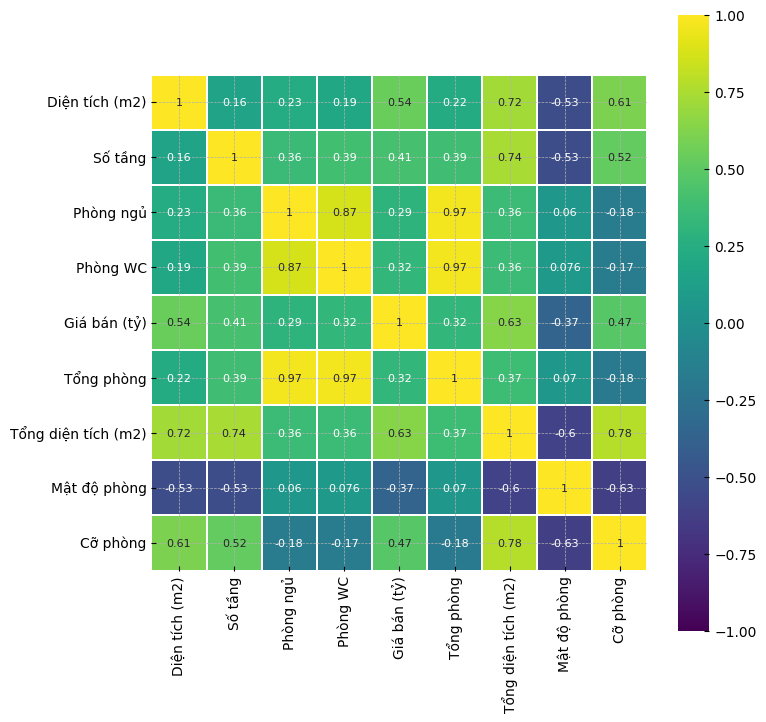

In [28]:
#Xem tương quan giữa các features với giá bán
check_df = create_combined_features(df_no_outliers)
corr = check_df.drop(['Quận, Huyện'], axis = 1).corr()
plt.figure(figsize = (8, 8))
sns.heatmap(corr, cmap = 'viridis', vmax = 1.0, vmin = -1.0, linewidths = 0.1, annot = True, annot_kws = {"size": 8}, square = True);

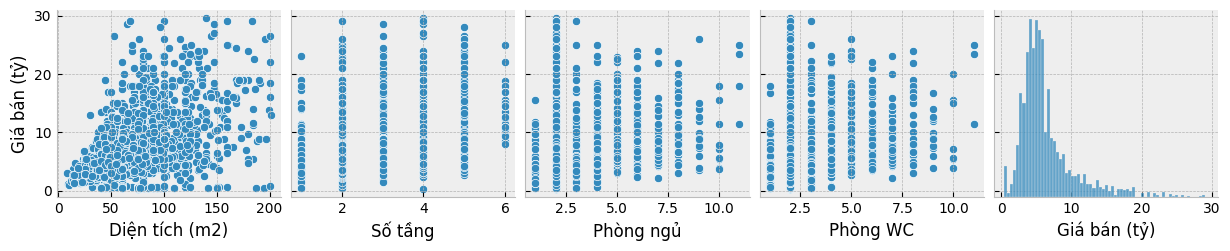

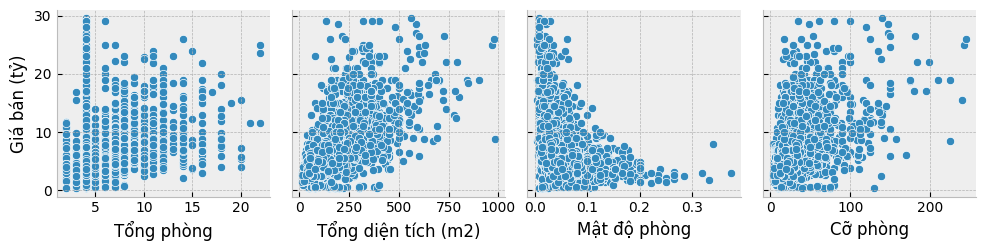

In [29]:
#Xem xét có mối liên hệ phi tuyến giữa features và target hay không
#Có thể thấy gần như không có mối liên hệ phi tuyến giữa từng cặp feature và target
numeric_cols = check_df.select_dtypes(include=[np.number]).columns.tolist()
for i in range(0, len(check_df.columns), 5):
    sns.pairplot(data=check_df,
                x_vars=numeric_cols[i:i+5],
                y_vars=['Giá bán (tỷ)'])

In [30]:
#Với diện tích và số tầng, ta thấy có sự độc lập giữa chúng. Hơn hết, hệ số tương quan với giá bán cũng là tương đối nên có thể giữa lại mà không cần thay thế bằng combined feature
#Ở đây, với số phòng ngủ và phòng WC, ta sẽ kết hợp thành features 'Tổng phòng'
#Ta cũng sẽ giữ lại feature 'Quận, Huyện' do trên thực tế đây là yếu tố ảnh hưởng rất lớn đến giá nhà ở TP.HCM.
df_no_outliers = check_df[['Diện tích (m2)', 'Số tầng', 'Tổng phòng', 'Quận, Huyện', 'Giá bán (tỷ)']]

In [31]:
#Các chỉ số VIF đã được cải thiện
vif_data = pd.DataFrame()
X = df_no_outliers.drop(['Giá bán (tỷ)', 'Quận, Huyện'], axis = 1)
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

          feature       VIF
0  Diện tích (m2)  4.434738
1         Số tầng  5.365999
2      Tổng phòng  5.930394


# Data Transformation

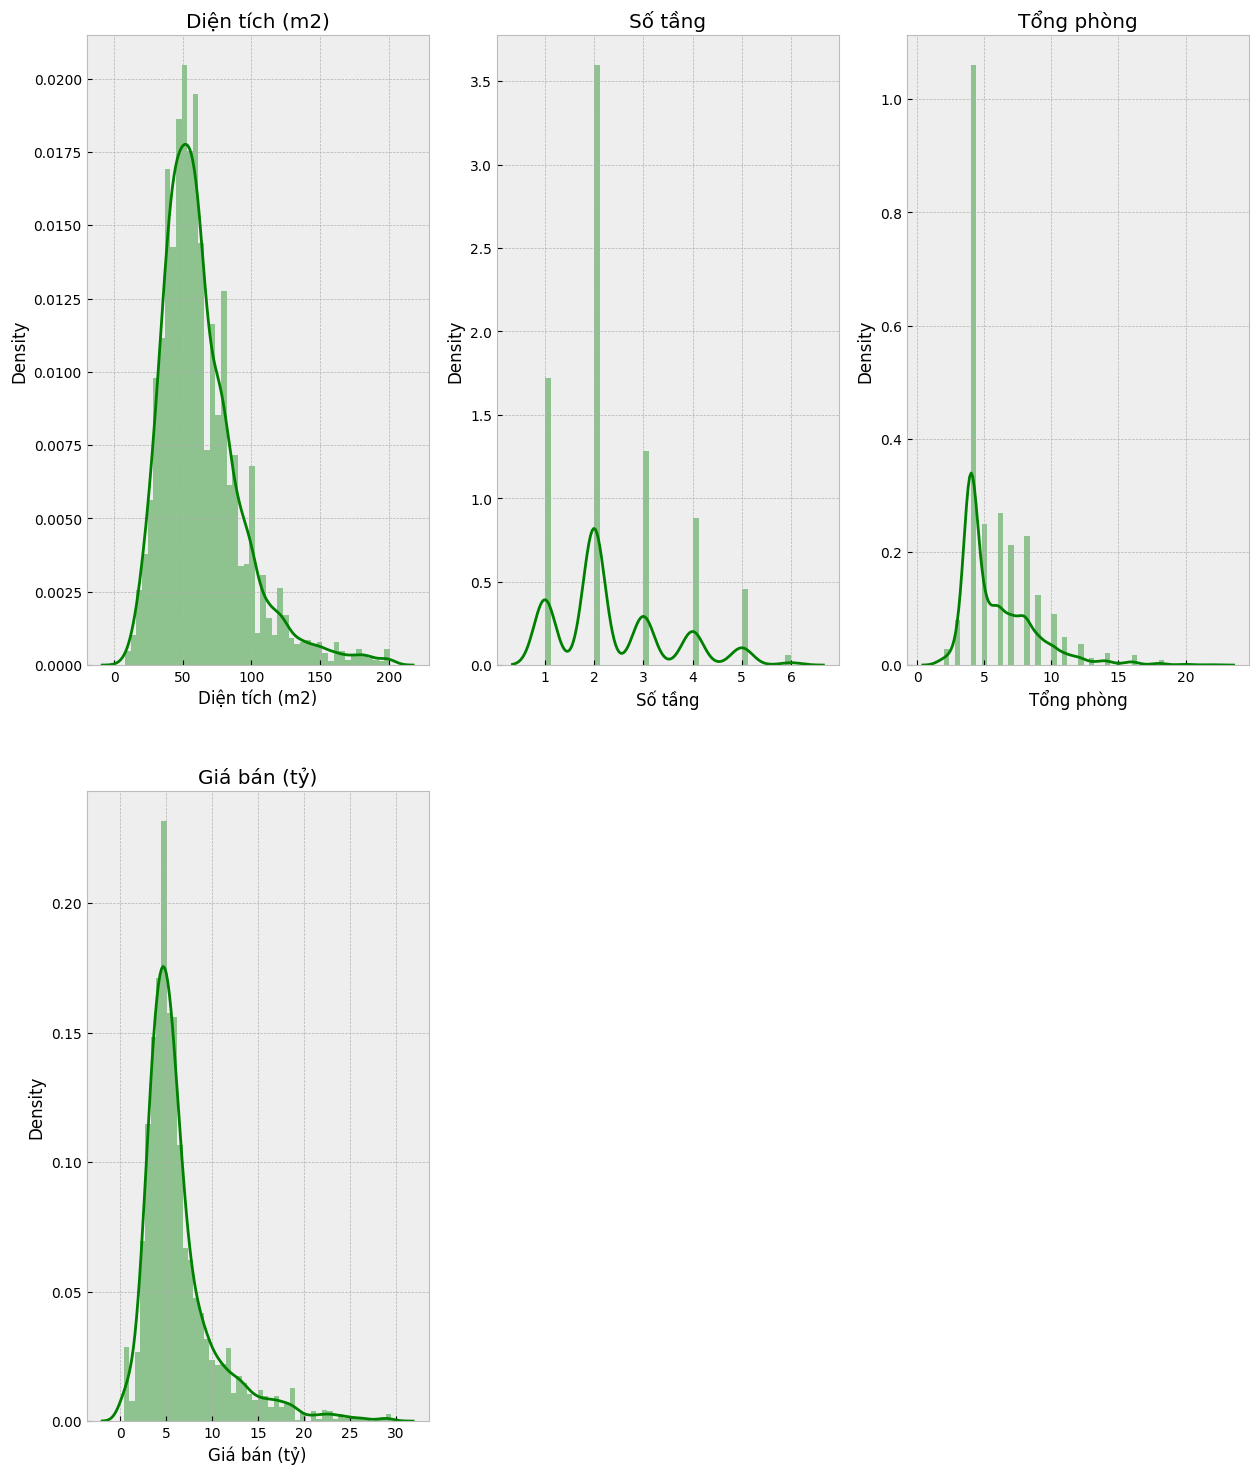

In [32]:
#Ta xem phân bố của các features và target sau khi lọc outliers
chart, axs = plt.subplots(2, 3, figsize=(15, 18))
n = 0
check_df = df_no_outliers.drop('Quận, Huyện', axis = 1)
for i in range(2):
    for j in range(3):
        if n< len(check_df.columns):
            sns.distplot(check_df[check_df.columns[n]], ax=axs[i, j], color='g')
            axs[i, j].set_title(check_df.columns[n])
        else:
            axs[i, j].axis('off')
        n = n+1
plt.show()

# Box-Cox:
Là một phương pháp biến đổi dữ liệu thống kê được sử dụng để làm cho các biến phụ thuộc (dependent variables) không tuân theo phân phối chuẩn trở nên gần với phân phối chuẩn.

Công thức của Box-Cox:
$$
y(\lambda) =
\begin{cases}
\frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\log(y), & \text{if } \lambda = 0
\end{cases}
$$

In [33]:
#Dễ thấy, giá bán và diện tích đều có phân phối gần với phân phối chuẩn nhưng bị lệch một chút.
#Ta có thể sử dụng boxcox để điều chỉnh các biến này về phân phối chuẩn giúp kết quả của bài toán có thể chính xác hơn
from scipy.stats import boxcox
df_transformed = df_no_outliers.copy()
df_transformed['Diện tích (m2)'], opt1 = boxcox(df_no_outliers['Diện tích (m2)'])
df_transformed['Giá bán (tỷ)'], opt2 = boxcox(df_no_outliers['Giá bán (tỷ)'])

# Encoding categogorical variables

In [34]:
#Ta xem sự phân bố tin đăng giữa các quận
count = Counter(df['Quận, Huyện'])
count
#Có thể thấy sự phân bố là không đều, nhiều quận/huyện có khá ít tin đăng, do đó khi áp dụng target encoding ta cần dùng phương pháp smoothing

Counter({'Gò Vấp': 673,
         'Quận 2': 73,
         'Bình Thạnh': 470,
         'Tân Phú': 426,
         'Quận 7': 106,
         'Phú Nhuận': 232,
         'Bình Chánh': 41,
         'Bình Tân': 667,
         'Quận 3': 89,
         'Quận 9': 248,
         'Tân Bình': 460,
         'Hóc Môn': 75,
         'Quận 12': 139,
         'Quận 8': 95,
         'Quận 6': 62,
         'Nhà Bè': 16,
         'Quận 10': 102,
         'Thủ Đức': 424,
         'Quận 11': 72,
         'Quận 5': 48,
         'Quận 4': 13,
         'Quận 1': 81,
         'Củ Chi': 8,
         'Cần Giờ': 1})

In [35]:
#Định nghĩa hàm smoothing label encoding
def smoothing_label_encoding(df, categorical_col, target_col, alpha=40):
    df = df.copy()
    global_mean = df[target_col].mean()
    agg = df.groupby(categorical_col)[target_col].agg(['mean', 'count'])
    smooth = (agg['mean'] * agg['count'] + global_mean * alpha) / (agg['count'] + alpha)
    df[categorical_col] = df[categorical_col].map(smooth)
    return df

In [36]:
df_encoded = smoothing_label_encoding(df_transformed, 'Quận, Huyện', 'Giá bán (tỷ)', alpha = 5)
df_encoded

,Diện tích (m2),Số tầng,Tổng phòng,"Quận, Huyện",Giá bán (tỷ)
0,4.804602,5.0,8.0,1.945142,2.669170
1,5.256694,2.0,8.0,2.688891,3.378415
2,4.599872,2.0,7.0,1.989939,1.777199
3,4.543991,1.0,4.0,1.918279,1.298031
4,4.599872,3.0,7.0,2.125123,1.615968
...,...,...,...,...,...
3970,6.271966,2.0,8.0,2.131047,2.842821
3971,4.262586,2.0,4.0,1.878560,1.401265
3972,3.726483,2.0,6.0,1.984876,1.922228
3973,4.456019,5.0,7.0,1.945142,2.260356


count    3975.000000
mean        1.937714
std         0.738123
min        -0.860667
25%         1.512721
50%         1.875469
75%         2.305563
max         4.314780
Name: Giá bán (tỷ), dtype: float64


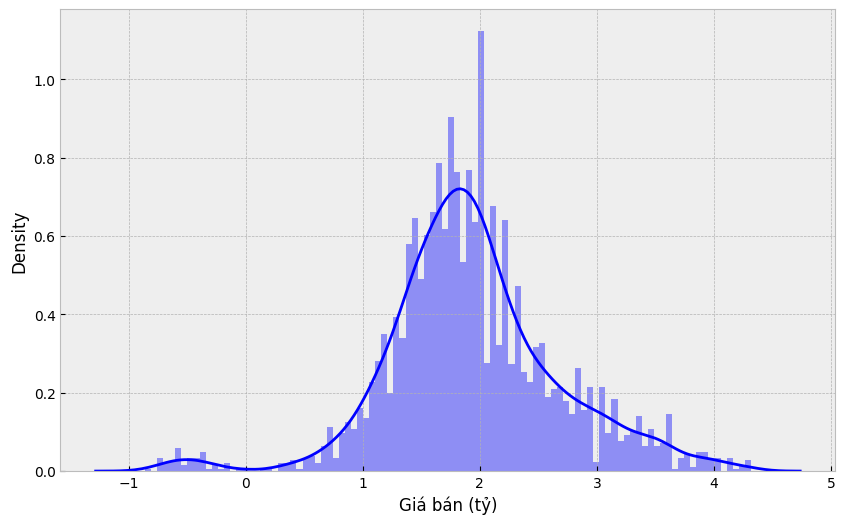

In [37]:
# Các thống kê mô tả của cột 'Giá bán (tỷ)'
print(df_encoded['Giá bán (tỷ)'].describe())
plt.figure(figsize = (10, 6))
# Biểu đồ phân phối của cột 'Giá bán (tỷ)'
sns.distplot(df_encoded['Giá bán (tỷ)'], color = 'b', bins = 100, hist_kws = {'alpha': 0.4});

# Scaling features

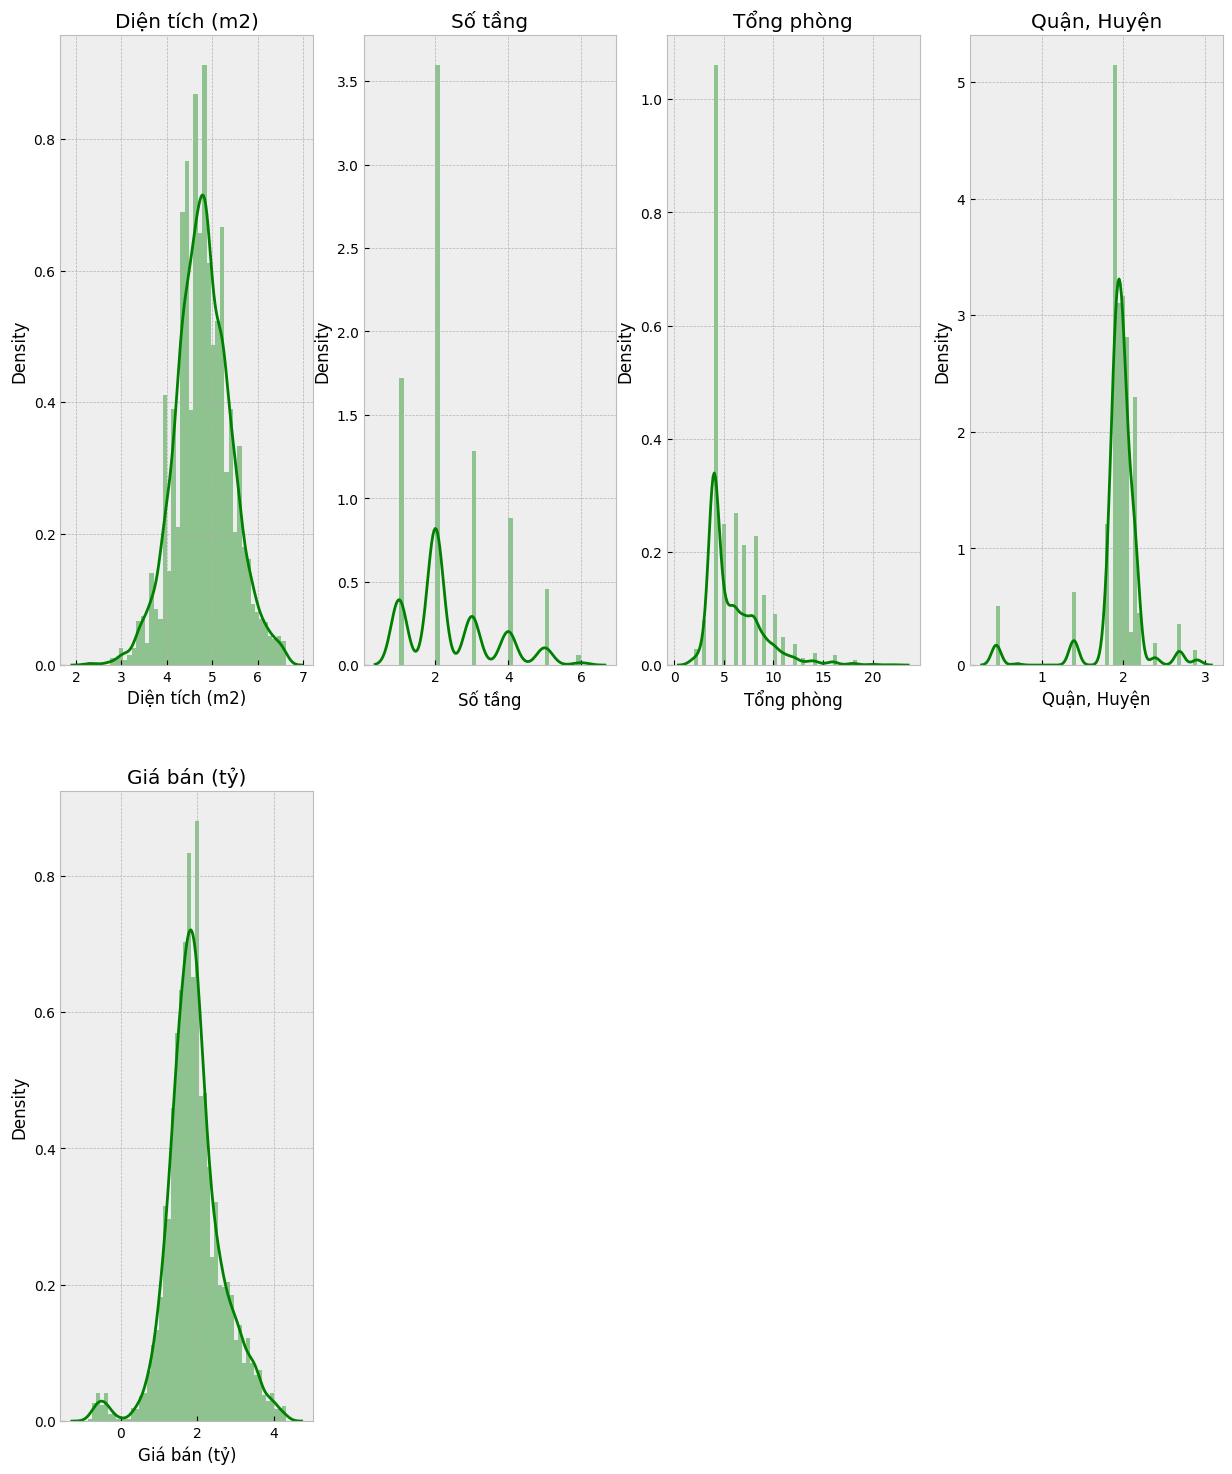

In [38]:
#Ta xem phân bố của các features để tiến hành phương pháp scaling phù hợp
chart, axs = plt.subplots(2, 4, figsize=(15, 18))
n = 0
for i in range(2):
    for j in range(4):
        if n< len(df_encoded.columns):
            sns.distplot(df_encoded[df_encoded.columns[n]], ax=axs[i, j], color='g')
            axs[i, j].set_title(df_encoded.columns[n])
        else:
            axs[i, j].axis('off')
        n = n+1
plt.show()

In [39]:
#Ta thấy các feature và target liên tục có biểu đồ histogram gần với dạng hình chuông nên ta có thể áp dụng phương pháp standardization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sta_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
scaled_features = {}
scaled_data_sta = sta_scaler.fit_transform(df_encoded.drop(['Tổng phòng', 'Số tầng'], axis = 1))
#Với các biến rời rạc như số phòng, số tầng ta sử dụng phương pháp min-max scaling
scaled_data_mm = mm_scaler.fit_transform(df_encoded[['Tổng phòng', 'Số tầng']])
scaled_df = pd.DataFrame(scaled_data_sta, columns=df_encoded.drop(['Tổng phòng', 'Số tầng'], axis = 1).columns)
scaled_df[['Tổng phòng', 'Số tầng']] = scaled_data_mm
scaled_df = scaled_df[['Diện tích (m2)', 'Số tầng', 'Tổng phòng', 'Quận, Huyện', 'Giá bán (tỷ)']]
scaled_df.head(10)

,Diện tích (m2),Số tầng,Tổng phòng,"Quận, Huyện",Giá bán (tỷ)
0,0.008346,0.8,0.30,0.017798,0.991092
1,0.742978,0.2,0.30,2.433521,1.952090
2,-0.324332,0.2,0.25,0.163298,-0.217491
3,-0.415137,0.0,0.10,-0.069454,-0.866744
4,-0.324332,0.4,0.25,0.602383,-0.435953
5,-0.324332,0.2,0.10,-0.069454,-0.842689
6,-1.439349,0.2,0.25,0.146853,-0.691266
7,1.264051,0.2,0.10,-4.864175,-3.293811
8,0.856110,0.2,0.10,-0.198464,0.971887
9,-0.030843,0.8,0.25,0.017798,1.209159


# Methodology

## Heatmap based on the address of the listed house.

In [40]:
# Tạo dataframe gồm 2 cột: Quận và Số lượng
count_district_df = pd.DataFrame.from_dict(count, orient = 'index').reset_index()
count_district_df.columns = ['Quận', 'Số lượng']

In [42]:
from geopy.geocoders import Nominatim
import pandas as pd

# Assuming the dataset has an 'address' column
district = {
    'District':['Quận 1', 'Quận 3', 'Quận 4', 'Quận 5', 'Quận 6', 'Quận 7', 'Quận 8',
                'Quận 10', 'Quận 11', 'Quận 12', 'Bình Tân', 'Bình Thạnh', 'Gò Vấp', 
                'Phú Nhuận', 'Tân Bình', 'Tân Phú', 'Thủ Đức', 'Bình Chánh', 'Cần Giờ',
                'Củ Chi', 'Hóc Môn', 'Nhà Bè', 'Quận 2', 'Quận 9']
}
df = pd.DataFrame(district)
addresses = df['District']

# Initialize the geolocator
geolocator = Nominatim(user_agent = "house_price_prediction")

# Function to get latitude and longitude
def geocode_address(address):
    try:
        location = geolocator.geocode(f"{address}, Vietnam")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

# Apply the function to the address column
df['latitude'], df['longitude'] = zip(*df['District'].apply(geocode_address))

# Remove rows with missing coordinates
df = df.dropna(subset = ['latitude', 'longitude'])

# Save the new dataset with latitude and longitude
df.to_csv('house_listings_with_coordinates.csv', index = False)

In [43]:
# Lấy tọa độ quận
coordinates_district = pd.read_csv('house_listings_with_coordinates.xls')
df_merged = pd.merge(count_district_df, coordinates_district, how = 'left', left_on = 'Quận', right_on = 'District')
df_merged.drop('District', axis = 1)

,Quận,Số lượng,latitude,longitude
0,Gò Vấp,673,10.834563,106.673960
1,Quận 2,73,10.835437,106.813775
2,Bình Thạnh,470,10.811789,106.703911
3,Tân Phú,426,10.791497,106.627843
4,Quận 7,106,10.737548,106.730224
...,...,...,...,...
19,Quận 5,48,10.755362,106.668544
20,Quận 4,13,10.760733,106.707552
21,Quận 1,81,10.777314,106.699991
22,Củ Chi,8,11.037057,106.502410


In [44]:
import folium
from folium.plugins import HeatMap

# Tạo bản đồ trung tâm tại TPHCM
map_center = [10.786521,106.675692]
m = folium.Map(location = map_center, zoom_start = 12)

# Chuẩn bị dữ liệu cho HeatMap
heat_data = [[row['latitude'], row['longitude'], row['Số lượng']] for index, row in df_merged.iterrows()]

# Thêm HeatMap vào bản đồ
HeatMap(heat_data).add_to(m)

# Hiển thị bản đồ
m

# Design a methodology to address the house price prediction problem

## Linear/Ridge/Lasso regression

Hồi quy tuyến tính là kỹ thuật thống kê đơn giản và được sử dụng rộng rãi nhất cho mô hình dự đoán. Nó cung cấp một phương trình, trong đó có các thuộc tính dưới dạng các biến độc lập và biến mục tiêu (Giá nhà trong trường hợp này).

## Phương trình Hồi quy Tuyến tính

Phương trình hồi quy tuyến tính có dạng:

$$
\hat{y} =\beta_0+ \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n +\epsilon
$$

Trong đó:
- $\hat{y}$ là biến phụ thuộc.
- $x_1, x_2, \ldots, x_n$ là các biến độc lập, giải thích cho $\hat{y}_i$.
- $\beta_0, \beta_1, \beta_2, \ldots, \beta_n$ là các hệ số hồi quy, với $\beta_0$ là hệ số chặn
- $\epsilon$ là thành phần sai số.

Cost function of a linear regression model:

$$\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Trong đó:
- $y_i$ là giá trị thực, $\hat{y}_i$ là giá trị dự đoán từ phương trình tuyến tính.

- $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ :Tổng bình phương sai số (ordinary least squares loss)



### Linear

In [45]:
df=scaled_df

In [46]:
X=df[['Diện tích (m2)','Số tầng','Tổng phòng','Quận, Huyện']]
y=df['Giá bán (tỷ)']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [48]:
# Tạo và huấn luyện mô hình hồi quy tuyến tính
model = LinearRegression()
# Check the shapes of your training data and target values
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
model.fit(X_train, y_train)

Shape of X_train: (3180, 4)
Shape of y_train: (3180,)


LinearRegression()

In [49]:
# Lấy hệ số hồi quy và hệ số chặn
coefficients = model.coef_
intercept = model.intercept_

# Tạo các tên cột tương ứng
feature_names = X.columns

# Xuất phương trình hồi quy
print("Phương trình hồi quy tuyến tính:")
equation = f"Giá bán = {intercept:.4f}"
for coef, feature in zip(coefficients, feature_names):
    equation += f" + {coef:.4f}*{feature}"
print(equation)

Phương trình hồi quy tuyến tính:
Giá bán = -0.4185 + 0.4919*Diện tích (m2) + 1.0695*Số tầng + 0.6504*Tổng phòng + 0.4736*Quận, Huyện


### Evaluate the trained model using appropriate metrics

#### Mean Squared Error (MSE)

Mean Squared Error là một trong những phép đo thường được sử dụng để đánh giá chất lượng của mô hình dự đoán, đặc biệt là trong bài toán hồi quy. MSE tính tổng trung bình của bình phương sai số (sự khác biệt giữa giá trị dự đoán và giá trị thực tế) trên toàn bộ các mẫu.

Công thức MSE được biểu diễn như sau:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
Trong đó:
- $n$ là số lượng mẫu của tập dữ liệu
- $y_i$ là giá trị thực tế của mẫu thứ i
- $\hat{y}_i$ là giá trị dự đoán của mô hình cho mẫu thứ i

In [50]:
print("Mean squared error(MSE):")
train_pred_mse = model.predict(X_train)
print(">> Train MSE: ", mean_squared_error(train_pred_mse, y_train))

test_pred_mse = model.predict(X_test)
print(">> Test MSE: ", mean_squared_error(test_pred_mse, y_test))

Mean squared error(MSE):
>> Train MSE:  0.40036979510564263
>> Test MSE:  0.38262417079471367


### Mean Absolute Error (MAE)

Mean Absolute Error là một độ đo để đánh giá sự sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế. MAE tính trung bình của giá trị tuyệt đối của các sai số.

Công thức MAE được biểu diễn như sau:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$


In [51]:
print("Mean absolute error(MAE):")
train_pred_mae = model.predict(X_train)
print(">> Train MAE: ", mean_absolute_error(train_pred_mae, y_train))

test_pred_mae = model.predict(X_test)
print(">> Test MAE: ", mean_absolute_error(test_pred_mae, y_test))

Mean absolute error(MAE):
>> Train MAE:  0.4685577084023281
>> Test MAE:  0.4546593084682874


### R-squared (Coefficient of Determination)

R-squared là một độ đo thống kê để đánh giá mức độ phù hợp của mô hình hồi quy với dữ liệu thực tế. Giá trị R-squared càng gần với 1 thì mô hình càng tốt, và càng gần với 0 thì mô hình càng không phù hợp.

Công thức R-squared được biểu diễn như sau:
$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Trong đó:

- $\bar{y}$ là giá trị trung bình của các giá trị thực tế $y_i$


In [52]:
print("R-squared(R2 score):")

train_pred_r2 = model.predict(X_train)
print(">> Train R2: ", r2_score(y_train,train_pred_r2))

test_pred_r2 = model.predict(X_test)
print(">> Test R2: ", r2_score(y_test,test_pred_r2 ))

R-squared(R2 score):
>> Train R2:  0.6006583454255483
>> Test R2:  0.6133926065415722


### Ưu điểm:
- Đơn giản, dễ hiểu, nhanh gọn và hiệu quả
- Dự đoán tốt cho các mối quan hệ tuyến tính
### Nhược điểm:
- Nhạy cảm với các giá trị ngoại lai
- Dễ bị overfitting khi có nhiều biến hoặc khi các biến tương quan mạnh.
- Không có điều khoản phạt điều chuẩn để kiểm soát độ phức tạp của mô hình.

## Sử dụng các biến thể của hồi quy tuyến tính để khắc phục một số nhược điểm của hồi quy tuyến tính cơ bản

- **Dùng R-squared (Coefficient of Determination) để so sánh hiệu suất giữa các mô hình**

### Ridge Regression

Ridge Regression,hay còn gọi là hồi quy bình phương tối thiểu chuẩn hóa (L2 regularization), nhằm giảm overfitting bằng cách thêm vào hàm mất mát (loss function) một thành phần chuẩn hóa L2
của các hệ số hồi quy. Điều này có tác dụng giảm các hệ số hồi quy đến gần 0 nhưng không phải là hoàn toàn 0

Phần tử chuẩn hóa L2 của hàm mất mát được biểu diễn như sau:
$$
\text{Loss}_{Ridge} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} \beta_j^2
$$

Trong đó:

- $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$:Tổng bình phương sai số (ordinary least squares loss)
- $\alpha$: tham số điều chuẩn (regularization parameter) quyết định mức độ phạt.
- $\sum_{j=1}^{p} \beta_j^2$:Tổng bình phương các hệ số hồi quy.

Việc thêm điều chuẩn $\sum_{j=1}^{p} \beta_j^2$ là để kiểm soát sự phức tạp của mô hình. Khi $\alpha$ càng lớn, sự ảnh hưởng của thành phần điều chuẩn càng cao, dẫn đến các hệ số hồi quy $\beta_j$ giảm xuống. Điều này làm giảm tính linh hoạt của mô hình và ngăn chặn sự overfitting.

In [53]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

reg_ridge = Ridge()
#lấy alpha là 1 tập hợp các giá trị ngẫu nhiên có thể có, thực hiện GridSearch để tìm tham số tốt nhất
hyperParameters={'alpha':[0.1,1.0,10.0,100.0]}
ridgeRegressor=GridSearchCV(reg_ridge,hyperParameters,scoring='r2',cv=5)
ridgeRegressor.fit(X_train,y_train)
print("Best value for alpha : ",ridgeRegressor.best_params_)
print("Best score for cost function: ", ridgeRegressor.best_score_)

# Get the best ridge regression model
best_ridge_model = ridgeRegressor.best_estimator_

# Predictions on training set
Y_train_pred = best_ridge_model.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)

# Predictions on testing set
Y_test_pred = best_ridge_model.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)


Best value for alpha :  {'alpha': 1.0}
Best score for cost function:  0.5963903930508966
R2 score on training set: 0.6006551809660938
R2 score on testing set: 0.613365292368756


In [54]:
# Hệ số hồi qui
print("Coef: ", best_ridge_model.coef_)
print("Intecept: ", best_ridge_model.intercept_)

Coef:  [0.4922458  1.06479587 0.64212706 0.47377392]
Intecept:  -0.41562000814379024


Do kết quả hiệu suất của mô hình Linear và Ridge khá tương đương nhau nên ta thử với chạy 100 lần và so sánh R2 trung bình

In [55]:
r2_linear=[]
r2_ridge=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_linear.append(r2_score(y_test, y_pred))
    reg_ridge = Ridge()
    #lấy alpha là 1 tập hợp các giá trị ngẫu nhiên có thể có, thực hiện GridSearch để tìm tham số tốt nhất
    hyperParameters={'alpha':[0.1,1.0,10.0,50.0,100.0]}
    ridgeRegressor=GridSearchCV(reg_ridge,hyperParameters,scoring='r2',cv=5)
    ridgeRegressor.fit(X_train,y_train)
    # Get the best ridge regression model
    best_ridge_model = ridgeRegressor.best_estimator_
    Y_test_pred = best_ridge_model.predict(X_test)
    r2_ridge.append(r2_score(y_test, Y_test_pred))

In [56]:
np.mean(r2_linear)

0.5995192357448603

In [57]:
np.mean(r2_ridge)

0.5995397630372181

Việc áp dụng Ridge Regression trong tập dữ liệu này đem lại hiệu quả gần như là ngang bằng với Linear Regression.

Đánh giá:
- Sự ảnh hưởng của điều kiện điều chuẩn chưa quá rõ ràng khi áp dụng trong tập dữ liệu này.
- Tuy nhiên, Linear regression không có regularization nên có thể khớp rất tốt với dữ liệu huấn luyện, thậm chí là quá tốt (overfitting), làm cho R² cao trong tập dữ liệu này. Tuy nhiên, điều này không đảm bảo rằng mô hình sẽ hoạt động tốt trên dữ liệu mới, có thể nói Ridge regression có thể sẽ ổn định hơn, ít bị ảnh hưởng bởi nhiễu trong dữ liệu hơn.
- Ridge regression không loại bỏ bất kỳ biến nào khỏi mô hình. Chỉ điều chuẩn các hệ số để cải thiện hiệu suất của mô hình.
- Ridge regression có thể thực hiện tối ưu hóa tham số điều chuẩn bằng việc sử dụng GridSearchCV.


### Lasso Regression

Lasso Regression, hay còn gọi là hồi quy chuẩn hóa tuyệt đối (L1 regularixation), cũng thêm một điều khoản phạt vào hàm mất mát nhưng sử dụng tổng giá trị tuyệt đối của các hệ số hồi quy.


Phương trình tối ưu hóa của Lasso Regression là:

$$
\text{Loss}_{Lasso} =  \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |\beta_j|
$$

Trong đó:

- $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ :Tổng bình phương sai số (ordinary least squares loss)
- $\alpha$: tham số điều chuẩn (regularization parameter) quyết định mức độ phtaj.
- $\sum_{j=1}^{p} |\beta_j|$: Tổng trị tuyệt đối của các hệ số hồi quy.

Alpha (α) là số hạng phạt biểu thị mức độ co rút (hoặc ràng buộc) sẽ được thực hiện trong phương trình. Với alpha được đặt thành 0, mô hình này tương đương với mô hình hồi quy tuyến tính và giá trị lớn hơn sẽ gây thiệt hại cho hàm tối ưu hóa. Do đó, hồi quy Lasso thu hẹp các hệ số và giúp giảm độ phức tạp của mô hình và hiện tượng đa cộng tuyến.

Alpha (α) có thể là bất kỳ số có giá trị thực nào từ 0 đến vô cùng; giá trị càng lớn thì hình phạt càng mạnh.

In [58]:
from sklearn.linear_model import Lasso

reg_lasso = Lasso()
reg_lasso.fit(X_train, y_train)
hyperParameters = {'alpha':[0.1,1.0,10.0,100.0]}
LassoRegressor = GridSearchCV(reg_lasso, hyperParameters, scoring='r2', cv=5)
LassoRegressor.fit(X_train,y_train)
print("Best value for alpha : ",LassoRegressor.best_params_)
print("Best score for cost function: ", LassoRegressor.best_score_)

# Get the best lasso regression model
best_lasso_model = LassoRegressor.best_estimator_

# Predictions on training set
Y_train_pred = best_lasso_model.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)

# Predictions on test set
Y_test_pred = best_lasso_model.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)

Best value for alpha :  {'alpha': 0.1}
Best score for cost function:  0.5033501241043463
R2 score on training set: 0.5069128464099387
R2 score on testing set: 0.49350333061257734


In [59]:
# Hệ số hồi qui
print("Coef: ", best_lasso_model.coef_)
print("Intecept: ", best_lasso_model.intercept_)

Coef:  [0.45017733 0.         0.         0.4202261 ]
Intecept:  0.0032206264077493134


#### Việc áp dụng Lasso Regression cho tập dữ liệu không đem lại hiệu quả hơn Linear Regression

Đánh giá:

- Việc sử dụng chuẩn L1 để điều chuẩn hóa hệ số hồi quy làm các tính năng ít quan trọng hơn trong tập dữ liệu sẽ bị loại bỏ khi bị phạt-hệ số hồi quy đưa về 0, dẫn đến việc mô hình giảm sự phù hợp với dữ liệu huấn luyện và có ít hơn đến 1 biến đầu vào so với Linear Regression


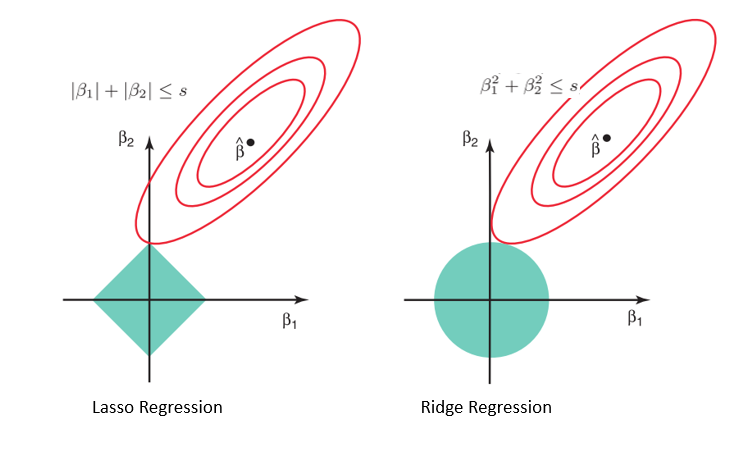

- Ridge Regression:

Vùng hạn chế được tạo ra bởi Hồi quy Ridge (khu vực khả dụng mà các hệ số có thể nằm trong đó) là hình tròn do thành phần phạt bình phương.

- Lasso Regression:

Vùng hạn chế được tạo ra bởi Hồi quy Lasso có hình dạng kim cương do thành phần phạt giá trị tuyệt đối.

=>Cả hai phương pháp đều xác định hệ số bằng cách tìm điểm đầu tiên nơi đường viền hình elip chạm vào vùng giới hạn. Vì Lasso Regression có hình dạng kim cương trong biểu đồ cho vùng bị ràng buộc, mỗi khi các vùng hình elip giao nhau với các góc này, ít nhất một trong các hệ số trở thành 0. Điều này là không thể trong mô hình Ridge Regression vì nó tạo thành một hình tròn và do đó các giá trị có thể bị thu nhỏ lại gần bằng 0, nhưng không bao giờ bằng 0.

## Decision Tree/Random Forest

### Decision Tree

Decision Tree là một mô hình học máy có cấu trúc phân loại dạng cây, mỗi nút trong cây đại diện cho một thuộc tính (hoặc đặc trưng), mỗi cạnh nối giữa các nút đại diện cho một quyết định dựa trên giá trị của thuộc tính đó, và mỗi lá của cây đại diện cho một nhãn hoặc một giá trị dự đoán.

Quá trình hoạt động: Mô hình này hoạt động bằng cách chia tập dữ liệu thành các phần nhỏ dựa trên các câu hỏi đơn giản về các đặc trưng của dữ liệu. Mỗi lần chia dữ liệu sẽ được thực hiện sao cho giảm thiểu độ đồng nhất trong mỗi nhóm con mới tạo ra. Quá trình này tiếp tục cho đến khi đạt được một điều kiện dừng, chẳng hạn như đạt đến một độ sâu tối đa hoặc không còn khả năng chia tiếp.

In [60]:
# Decision Tree Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [61]:
# Predictions on training set
Y_train_pred = dt_model.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)

# Predictions on test set
Y_test_pred = dt_model.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)


R2 score on training set: 0.9698228540439526
R2 score on testing set: 0.4712228276309761


Việc sử dụng 1 cây quyết định không đem lại hiệu suất khá ổn

Đánh giá:

- Bị mắc phải nhược điểm là bị overfitting khi R2 score ở tập train rất cao nhưng tập test lại thấp hơn nhiều lần
- Đây không phải mô hình mạnh khi sử dụng đơn

### Random Forest

Random Forest là một phương pháp mở rộng từ cây quyết định. Thay vì sử dụng một cây quyết định duy nhất, Random Forest sử dụng nhiều cây quyết định và kết hợp kết quả từ tất cả các cây để đưa ra dự đoán cuối cùng. Mỗi cây được huấn luyện trên một phần của dữ liệu (theo nguyên tắc tái chọn mẫu với việc thay thế) và sau đó kết hợp kết quả từ tất cả các cây để đưa ra dự đoán.

In [62]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100) # Use RandomForestRegressor for regression
rf_regressor.fit(X_train, y_train)
# Predictions on training set
Y_train_pred = rf_regressor.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)

# Predictions on test set
Y_test_pred = rf_regressor.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)

R2 score on training set: 0.9336355592658949
R2 score on testing set: 0.6676740054647465


#### Random Forest đem lại hiệu suất cao hơn so với Linear/Ridge Regression

Đánh giá:

- Random Forest có khả năng mô hình hóa các mối quan hệ phi tuyến tính và tương tác giữa các đặc trưng một cách tự nhiên hơn.
- Dữ liệu thực tế có các thuộc tính có mối quan hệ phức tạp, không phải tuyến tính nên bằng việc xây dựng nhiều cây quyết định trở nên đúng đắn hơn.
- Random Forest làm giảm sự tác động của các outlier
- Việc kết hợp nhiều cây quyết định, Random Forest cung cấp các dự đoán tốt hơn bằng cách giảm thiểu phương sai so với một cây quyết định đơn lẻ (Decision Tree) hoặc mô hình tuyến tính.
- Tuy nhiên kết quả vẫn thể đang bị overfitting

Áp dụng thêm GridSearchCV để tìm tham số
tối ưu, xử lý việc mô hình còn bị overfitting

- n_estimators: Số lượng cây trong rừng. Tăng giá trị này giúp giảm variance nhưng tăng thời gian huấn luyện.
- max_depth: Độ sâu tối đa của cây. Giới hạn giá trị này giúp giảm overfitting.
- min_samples_split: Số lượng mẫu tối thiểu để chia một nút. Tăng giá trị này giúp giảm overfitting.
- min_samples_leaf: Số lượng mẫu tối thiểu trong một lá. Tăng giá trị này giúp giảm overfitting.

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Thiết lập siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [100,150],
    'max_depth': [None,5,10],
    'min_samples_split': [5,7,10],
    'min_samples_leaf': [5,7,10]
}
rf_regressor = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='r2', verbose=1)#verbose=1:xuất ra các thông báo cơ bản về tiến trình

# Huấn luyện mô hình trên tập huấn luyện
grid_search.fit(X_train, y_train)

# Dự đoán giá nhà trên tập kiểm tra với mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Predictions on training set
Y_train_pred = best_rf_model.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)

# Predictions on test set
Y_test_pred = best_rf_model.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
R2 score on training set: 0.7856587808879054
R2 score on testing set: 0.6691164969856548


In [64]:
print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


## Áp dụng GridSearchCV để tìm các tham số cho mô hình Random Forest giúp mô hình tránh overfitting

Đánh giá:

- n_estimators=150:Số lượng cây lớn nhất trong mảng lưới nên có thể đạt được mô hình mạnh mẽ nhất
- max_dept=None:nghĩa là các nút sẽ mở rộng cho đến khi tất cả các lá chứa ít hơn min_samples_split mẫu


Vấn đề mắc phải: Trong tập dữ liệu này mô hình Random Forest bị mắc phải vấn đề overfitting nên cần phải tối ưu các tham số. Điều này làm R2 trong tập test giảm đi một chút.

### Gradient Boosting

Quá trình hoạt động của Gradient Boosting là một phương pháp học máy ensemble (kết hợp nhiều mô hình) trong đó các mô hình yếu được học tuần tự và cải thiện dựa trên sai số của mô hình trước đó

- Khởi tạo Mô hình Ban đầu: Bắt đầu với một mô hình đơn giản như một hàm hằng số (trung bình)
- Tính Residuals: Tính sai số (residuals) giữa dự đoán của mô hình hiện tại và giá trị thực tế trên tập huấn luyện.
- Huấn luyện Mô hình Yếu: Dự đoán residuals.
- Cập nhật Mô hình Tổng Hợp: Cập nhật mô hình tổng hợp (ensemble model) bằng cách thêm mô hình yếu mới, dựa trên một tỷ lệ học (learning rate) nhỏ để tránh quá khớp.
- Lặp lại Quá Trình: Lặp lại quá trình nhiều lần. Mỗi lần lặp, một mô hình yếu mới được huấn luyện để cải thiện khả năng dự đoán của mô hình tổng hợp.
- Kết hợp các Mô hình Yếu: Tạo thành một mô hình mạnh hơn có khả năng dự đoán tốt hơn.

In [65]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Khởi tạo mô hình Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.3, max_depth = 3, random_state = 42)

# Huấn luyện mô hình trên tập huấn luyện
gbr.fit(X_train, y_train)

# Predictions on training set
Y_train_pred = gbr.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)
train_mse = mean_squared_error(Y_train_pred, y_train)

# Predictions on test set
Y_test_pred = gbr.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)
test_mse = mean_squared_error(Y_test_pred, y_test)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)
print("MSE on training set:", train_mse)
print("MSE on testing set:", test_mse)

R2 score on training set: 0.7709384602166427
R2 score on testing set: 0.6589271825670628
MSE on training set: 0.23208234168182557
MSE on testing set: 0.32307515387061175


### *Tương tự như Random Forest, Gradient Boosting kết hợp nhiều mô hình yếu với nhau.Tuy nhiên, trong tập dữ liệu này thay vì việc điều chỉnh tham số trong Random Forest để giảm overfitting thì với Gradient Boosting ta có thể điều chỉnh tham số để nâng cao hiệu suất.

In [66]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa các tham số cần tối ưu
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100,150],
    'max_depth': [None,5,10],
    'min_samples_split': [5,7,10],
    'min_samples_leaf': [5,7,10]
}

# Khởi tạo Grid Search
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Huấn luyện Grid Search
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best Parameters: {grid_search.best_params_}")

# Dự đoán trên tập kiểm tra với mô hình tốt nhất
best_model = grid_search.best_estimator_
# Predictions on training set
Y_train_pred = best_model.predict(X_train)
train_score = r2_score(y_train, Y_train_pred)

# Predictions on test set
Y_test_pred = best_model.predict(X_test)
test_score = r2_score(y_test, Y_test_pred)

print("R2 score on training set:", train_score)
print("R2 score on testing set:", test_score)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 150}
R2 score on training set: 0.7858404344648571
R2 score on testing set: 0.6860282037006158


## Giới thiệu một vài mô hình nâng cấp của gradient boosting:

- Chỉ nêu một số tính năng nổi bật của các mô hình nâng cấp so với mô hình Gradient Boosting truyền thống.

### XGBoost (Extreme Gradient Boosting)

- Regularization: XGBoost hỗ trợ cả L1 và L2 regularization để ngăn chặn overfitting, giúp mô hình tổng quát tốt hơn.

- Handling Missing Values: XGBoost có khả năng tự động xử lý giá trị thiếu, giúp cải thiện hiệu suất mô hình khi dữ liệu có thiếu hụt.

- Parallel Processing: XGBoost hỗ trợ xử lý song song, tăng tốc độ huấn luyện.

- Tree Pruning: XGBoost sử dụng thuật toán tree pruning để cắt tỉa các cây quyết định, loại bỏ các node không cần thiết để giảm độ phức tạp của mô hình.

- Sparsity Awareness: XGBoost được thiết kế để xử lý tốt dữ liệu thưa, tối ưu hóa hiệu quả bộ nhớ và tốc độ.

In [67]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Khởi tạo mô hình XGBoost Regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Huấn luyện mô hình trên tập huấn luyện
xgbr.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = xgbr.predict(X_test)

# Tính toán và in ra r2
r2 = r2_score(y_test, y_pred)
print(f'{r2}')


0.6568608236739462


### CatBoost (Categorical Boosting)


In [68]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

# Khởi tạo mô hình CatBoost Regressor và ẩn các cảnh báo
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)

# Huấn luyện mô hình trên tập huấn luyện
catboost.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = catboost.predict(X_test)

# Tính toán và in ra r2
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')


R2 score: 0.6468863282185268


### LightGBM (Light Gradient Boosting Machine)

- Leaf-wise Growth: LightGBM tạo cây quyết định theo chiều sâu của node lá (leaf-wise) thay vì level-wise như gradient boosting truyền thống, giúp cây sâu hơn và tối ưu hóa tốt hơn.
- Histogram-based Learning: LightGBM sử dụng histogram-based learning để giảm số lượng phép tính và tăng tốc độ huấn luyện.
- Handling Large Data: LightGBM được thiết kế để xử lý dữ liệu lớn một cách hiệu quả, đặc biệt khi làm việc với các tập dữ liệu có hàng triệu mẫu.
- Categorical Features: LightGBM hỗ trợ đặc biệt cho các đặc trưng phân loại, giúp cải thiện hiệu suất trên các dữ liệu có nhiều đặc trưng phân loại.


In [69]:
import lightgbm as lgb
from sklearn.metrics import r2_score

# Khởi tạo mô hình LightGBM Regressor và ẩn các cảnh báo
lgbm = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1)

# Thay đổi tên cột trong X_train để loại bỏ các ký tự đặc biệt
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Huấn luyện mô hình trên tập huấn luyện
lgbm.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = lgbm.predict(X_test)

# Tính toán và in ra r2
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')

R2 score: 0.6509894633405056


- Categorical Feature Handling: CatBoost xử lý trực tiếp các đặc trưng phân loại mà không cần mã hóa đặc trưng (one-hot encoding), giúp giảm độ phức tạp và tăng hiệu suất.
- Ordered Boosting: CatBoost sử dụng ordered boosting để tránh bias do sử dụng cùng dữ liệu cho cả huấn luyện và kiểm tra, giúp mô hình tổng quát tốt hơn.
- Efficient Handling of Missing Data: CatBoost có khả năng tự động xử lý các giá trị thiếu, cải thiện hiệu suất trên các tập dữ liệu không đầy đủ.
- Robust to Overfitting: CatBoost có các cơ chế giảm thiểu overfitting, giúp mô hình tổng quát tốt hơn và ổn định hơn.

# Deep learning models

## Pytorch
PyTorch is a powerful, yet easy-to-use deep learning library for Python, mainly used for applications such as computer vision and natural language processing.The flexibility of PyTorch allows easy integration of new data types and algorithms, and the framework is also efficient and scalable, since it was designed to minimize the number of computations required and to be compatible with a variety of hardware architectures.

### Pros:
- Easy to use
- Compatible with Python libraries
- Comprehensive documentation
- Dynamic computation graphs
- Strong community and industry support
- Good for research

### Cons:
- Lacks a visual interface
- Harder to deploy models to mobile devices
- Lack of training models

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

# Prepare model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x     

## Sử dụng thuật toán Adam

### Một trong những thành phần chính của Adam là các trung bình động trọng số mũ (hay còn được gọi là trung bình rò rỉ) để ước lượng cả động lượng và mô-men bậc hai của gradient. Cụ thể, nó sử dụng các biến trạng thái:

### ${v}_t \leftarrow \beta_1 {v}_{t-1} + (1 - \beta_1) \mathbf{g}_t$, 
### ${s}_t  \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2$

### $\beta_1$ và $\beta_2$ là các tham số trọng số không âm,phổ biên: $\beta_1$=0.9 và $\beta_2$=0.99. Điều này có nghĩa là ước lượng phương sai di chuyển chậm hơn nhiều so với số hạng động lượng

### Ta sử dụng $$\sum_{i=0}^{t}\beta^i=(1-\beta^t)/(1-\beta)$$ để chuẩn hóa lại các số hạng

### Tương tự, các biến trạng thái được chuẩn hóa như sau: $$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

### Với các ước lượng thích hợp, bây giờ chúng ta có thể viết ra các phương trình cập nhật. Đầu tiên, chúng ta điều chỉnh lại giá trị gradient $$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

### Tổng hợp lại tất cả các điều trên để tính toán bước cập nhật:
### $$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'$$

### Ưu điểm:

- Cập nhật tham số hiệu quả với một tỷ lệ học tập (learning rate) thường tự động điều chỉnh.
- Hiệu quả với các bài toán có dữ liệu lớn và không tuyến tính.
- Thường có tốc độ hội tụ nhanh hơn.
### Nhược điểm:

- Đôi khi có thể yêu cầu cấu hình thêm các siêu tham số như betas (beta1, beta2) để tối ưu hóa chính xác hơn.
- Có thể có hiện tượng không ổn định trong quá trình học nếu tỷ lệ học tập không được thiết lập phù hợp.

In [71]:
model = Model()
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_torch = torch.tensor(X_train_np).type(torch.float32)
y_train_torch = torch.tensor(y_train_np).type(torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(X_test_np).type(torch.float32)
y_test_torch = torch.tensor(y_test_np).type(torch.float32).unsqueeze(1)

In [72]:
for x, target in zip(X_train_torch, y_train_torch):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

In [73]:
total_loss = 0
predictions = []
actuals = []
for x, target in zip(X_test_torch, y_test_torch):
    outputs = model(x)
    total_loss += criterion(outputs, target)
    predictions.extend(outputs.tolist())
    actuals.extend(target.tolist())
    
avg_loss = total_loss/len(X_test_torch)
pt_r2 = r2_score(actuals, predictions)

print(f">> MSE using Pytorch: {avg_loss}")
print(f">> R2 score using Pytorch: {pt_r2}")

>> MSE using Pytorch: 0.4027349650859833
>> R2 score using Pytorch: 0.5748297685052551


## Sử dụng thuật toán SGD
### Ưu điểm:

#### - Dễ triển khai và cấu hình.
#### - Hiệu quả với các bộ dữ liệu lớn.
#### - Đôi khi cho kết quả tốt hơn khi được cấu hình và tinh chỉnh một cách kỹ lưỡng.
### Nhược điểm:

#### - Có thể dễ bị vướng vào các điểm tối ưu cục bộ.
#### - Yêu cầu phải chọn tỷ lệ học tập thích hợp và thường cần thời gian để tinh chỉnh

In [74]:
model = Model()
optimizer = optim.SGD(model.parameters(), lr = 0.05)
criterion = nn.MSELoss()

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_tensor = torch.tensor(X_train_np, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype = torch.float32).unsqueeze(1)  # Thêm chiều để phù hợp với shape của outputs
X_test_tensor = torch.tensor(X_test_np, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype = torch.float32).unsqueeze(1)

# Huấn luyện mô hình
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [75]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'MSE: {test_loss}')
    
    r2 = r2_score(y_test_tensor, y_pred)
    print(f'R^2 score: {r2}')

MSE: 0.3722998797893524
R^2 score: 0.6069602778812211


In [76]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score

### >> Đây là một bài toán về mô hình tuyến tính nên lựa chọn thuật toán SGD sẽ giúp tối ưu hiệu suất dự đoán

## Tensorflow
In deep learning, tensors are a fundamental data structure that is very similar to arrays and matrices, with which we can efficiently perform mathematical operations on large sets of data. A tensor can be represented as a matrix, but also as a vector, a scalar, or a higher-dimensional array.


### Pros:
- Scalable
- Open Source Platform
- Graphs
- Debugging
- Compatible

### Cons:
- No windows support
- Slow
- Frequent updates
- Architectural limitation

### Thuật toán Adam và SGD cũng áp dụng tương tự vào mô hình TensorFlow

In [77]:
import tensorflow as tf
inputs = tf.keras.Input(shape=(X.shape[1],))
hidden = tf.keras.layers.Dense(64, activation = 'relu')(inputs)
hidden = tf.keras.layers.Dense(64, activation = 'relu')(hidden)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(hidden)

tf_model = tf.keras.Model(inputs, outputs)
tf_model.compile(
    optimizer = 'sgd',
    loss = 'mse'
)
history = tf_model.fit(X_train, y_train, validation_split = 0.2, batch_size = 32, epochs = 10)
y_pred = tf_model.predict(X_test)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7834 - val_loss: 0.4856
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4354 - val_loss: 0.4663
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4080 - val_loss: 0.4604
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3942 - val_loss: 0.4540
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3776 - val_loss: 0.4395
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3634 - val_loss: 0.4320
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3933 - val_loss: 0.4322
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3764 - val_loss: 0.4336
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3838 - val_loss: 0.4274
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3802 - val_loss: 0.4367
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [78]:
tf_mse = tf_model.evaluate(X_test, y_test)
tf_r2 = r2_score(y_test, y_pred)
print(f">> MSE using Tensorflow: {tf_mse}")
print(f">> R² Score: {tf_r2}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3537 
>> MSE using Tensorflow: 0.3842845857143402
>> R² Score: 0.5943078591524178


In [79]:
# Pytorch benchmaks
print(f">> MSE using Pytorch: {avg_loss}")
print(f">> R2 score using Pytorch: {pt_r2}")

>> MSE using Pytorch: 0.4027349650859833
>> R2 score using Pytorch: 0.5748297685052551


In [80]:
# Tensorflow benchmarks
print(f">> MSE using Tensorflow: {tf_mse}")
print(f">> R² Score: {tf_r2}")

>> MSE using Tensorflow: 0.3842845857143402
>> R² Score: 0.5943078591524178


Việc áp dụng Tensor Flow trong tập dữ liệu đem lại hiệu quả hơn pytorch

# Showing results (on testing set) predicted by selected models

In [81]:
#Hàm chuyển đổi kết quả theo quy chiếu như dữ liệu ban đầu
def inverse_results(X):
    mean = sta_scaler.mean_[2]
    std = sta_scaler.scale_[2]
    X = X*std + mean
    inversed = np.power((X * opt2 + 1), (1 / opt2))
    return inversed

In [82]:
#Gradient Boosting
y_pred_grb = inverse_results(best_model.predict(X_test))
y_actual = inverse_results(y_test)
print("R² score on testing set (compared with original data):", r2_score(y_actual, y_pred_grb))

R² score on testing set (compared with original data): 0.6500102965173393


In [83]:
#Tạo dataframe theo dõi kết quả của 1 vài models
df_result = pd.merge(y_test, df_no_outliers, left_index=True, right_index=True, how = 'inner')
df_result = df_result.drop('Giá bán (tỷ)_x', axis = 1)
df_result = df_result.rename(columns={'Giá bán (tỷ)_y': 'Giá bán'})
df_result['Giá bán (dự đoán theo GB)'] = y_pred_grb
pd.set_option("display.max_rows", 30)
df_result.head(30)

,Diện tích (m2),Số tầng,Tổng phòng,"Quận, Huyện",Giá bán,Giá bán (dự đoán theo GB)
3945,44.0,2.0,7.0,Tân Phú,4.50,4.505678
1019,37.0,4.0,11.0,Bình Thạnh,5.78,5.889166
1106,52.0,2.0,5.0,Quận 9,3.30,3.808654
1044,95.0,1.0,5.0,Quận 9,4.90,4.405568
3582,90.0,2.0,9.0,Thủ Đức,7.00,7.336115
2107,50.0,1.0,4.0,Bình Thạnh,5.20,4.808034
2918,36.0,2.0,6.0,Quận 10,1.45,5.017036
1344,54.0,2.0,7.0,Gò Vấp,6.50,5.263958
3590,80.0,2.0,9.0,Quận 2,16.00,15.135908
3109,62.0,6.0,13.0,Gò Vấp,14.50,13.645853


# Report

### Giới thiệu:
- Đây là mô hình dự đoán giá nhà
- Sử dụng các mô hình cơ bản và nâng cao để thực hiện bài toán trên
- Đánh giá mô hình qua các thông số dự đoán để

### Phương pháp:
- Cào các dữ liệu liên quan đến nhà như: diện tích, phòng ngủ, số tầng, địa điểm và giá bán nhà
- Tiến hành tiền xử lý dữ liệu mô hình như: xử lý các giá trị khuyết, giá trị ngoại lai, chuẩn hóa giá trị chuỗi
- Chọn các thuộc tính trọng yếu của mô hình qua biểu hiện tương quan của chúng
- Chuẩn hóa thuộc tính và huấn luyện mô hình
- Sử dụng các mô hình cơ bản như LinearRegression, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor, CatBoostRegressor, DecisionTreeRegressor, XGBoost, LightBGM
- Sử dụng các mô hình nâng cao như Pytorch, TensorFlow

### Đánh giá:
- Tiến hành so sánh thông số của các mô hình qua các thông số như: R2_score, MSE, MAE
- Trong những mô hình cơ bản, mô hình GradientBoostingRegressor cho thông số tối ưu nhất đối với tập dữ liệu:
- R2 score on testing set: 0.6555955743517474
- MSE on testing set: 0.35086338618652974
- Sự chênh lệch giữa r2_score trên tập train và tập test khá ít, chỉ số không quá cao giúp tránh hiện tượng overfitting (quá khớp)
- Trong những mô hình nâng cao (deep learning): vì chỉ có 2 mô hình được sử dụng trong bài nên chúng ta sẽ so sánh chỉ số của 2 mô hình, mô hình TensorFlow cho thông số tối ưu nhất đối với tập dữ liệu:
- R2_score using Pytorch: 0.6081158001342726 
- MSE using Pytorch: 0.39361074566841125
- R2_score using TensorFlow: 0.6217128837047946
- MSE using Tensorflow: 0.37995368242263794
- Việc lựa chọn mô hình tối ưu cho bài toán sẽ còn tùy thuộc vào suy nghĩ từng cá nhân và mục đích của bài toán
- Vì bài toán này không quá phức tạp, không cần sử dụng đến các mô hình nâng, chính vì vậy GradientBoostingRegressor là lựa chọn tối ưu nhất, sự đơn giản cần thiết và đạt hiệu quả cao 

### Kết luận:
- Đồ án này chủ yếu tập trung vào kĩ thuật dự đoán mô hình và phát triển thuật toán
- Bằng cách tận dụng những mô hình tiên tiến, chúng góp phần hỗ trợ đánh giá phần nào về biến động giá nhà hiện nay
- Các nhà môi giới bất động sản có thể sử dụng mô hình để đặt giá cạnh tranh cho các bất động sản dựa trên các đặc điểm quan trọng và nhu cầu thị trường
- Các nhà đầu tư có thể xác định các bất động sản được định giá thấp hơn giá trị thực với tiềm năng tăng giá cao, tận dụng các dự đoán của mô hình
- Giá nhà có thể có nhiều biến động so với mô hình dự đoán tùy thuộc vào nhiều điều kiện khác như: điều kiện phát triển kinh tế, cơ sở hạ tầng xung quanh
- Giúp mọi người có cái nhìn rõ hơn về thị trường bất động sản hiện nay